In [17]:
import cv2
import glob
import time
import pickle
import numpy as np
import os.path as path
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from IPython.display import HTML
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

(0, 256)

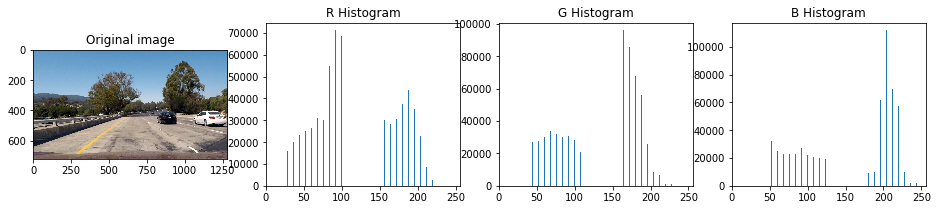

In [19]:
img = mpimg.imread('test_images/test1.jpg')
rhist, ghist, bhist, bin_centers, hist_features = color_hist(img)
fig = plt.figure(figsize=(16,3))
plt.subplot(141)
plt.imshow(img)
plt.title('Original image')
plt.subplot(142)
plt.bar(bin_centers, rhist[0])
plt.title('R Histogram')
plt.xlim(0, 256)
plt.subplot(143)
plt.bar(bin_centers, ghist[0])
plt.title('G Histogram')
plt.xlim(0, 256)
plt.subplot(144)
plt.bar(bin_centers, bhist[0])
plt.title('B Histogram')
plt.xlim(0, 256)

In [20]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

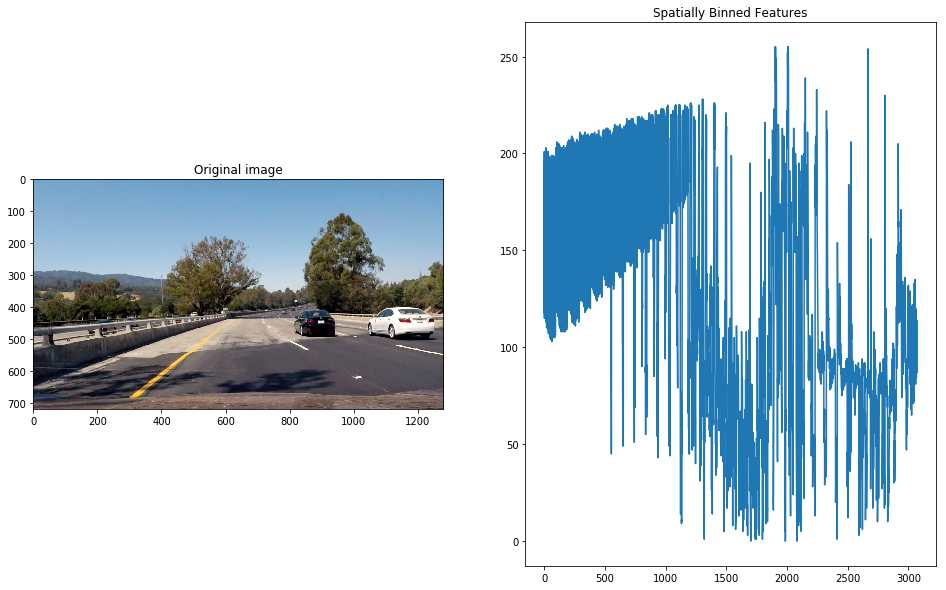

In [21]:
img = mpimg.imread('test_images/test4.jpg')
features = bin_spatial(img)
fig = plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.plot(features)
plt.title('Spatially Binned Features')

In [22]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

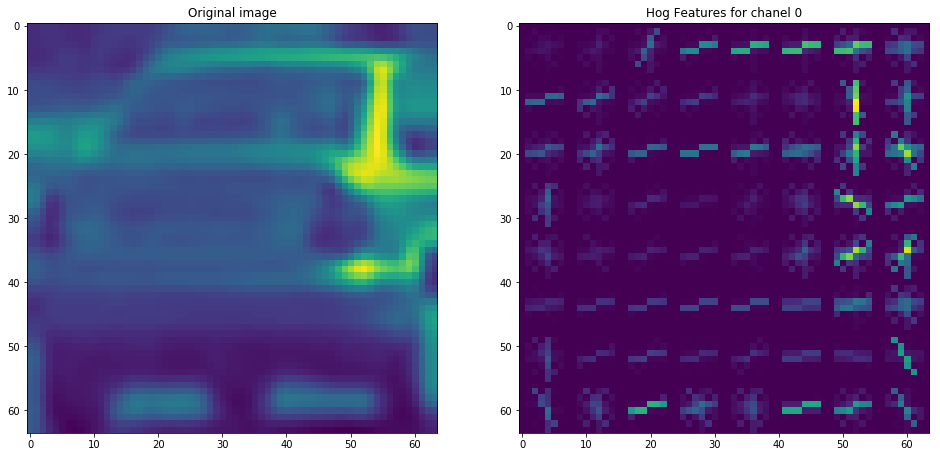

In [23]:
img = mpimg.imread('test_images/vehicles1.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
features, hog_image = get_hog_features(img, 9, 8, 2, True)
fig = plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.imshow(hog_image)
plt.title('Hog Features for chanel 0')


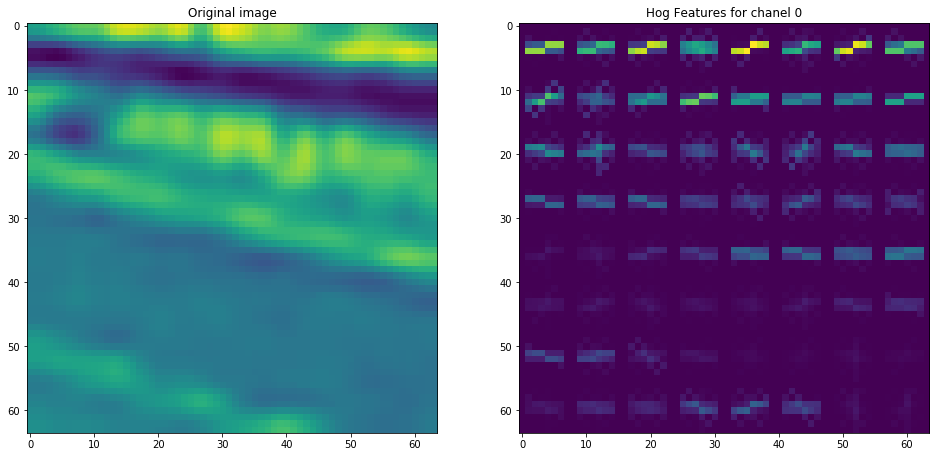

In [24]:
img = mpimg.imread('test_images/non_vehicle1.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
features, hog_image = get_hog_features(img, 9, 8, 2, True)
fig = plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.imshow(hog_image)
plt.title('Hog Features for chanel 0')

In [25]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()
def extract_features(imgs, cspace='YCrCb', orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                     spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [26]:
def train_test_svm(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    return svc, X_scaler

In [28]:
svc, X_scaler = None, None
if path.exists('svc.p') and path.exists('X_scaler.p'):
    print('svc.p and X_scaler.p found using that instead of training again')
    svc = pickle.load(open('svc.p', 'rb'))
    X_scaler = pickle.load(open('X_scaler.p', 'rb'))
    print('svc ', svc)
else:
    cars, notcars = [], []
    for image in glob.glob('data/non-vehicles/**/*.png'):
        notcars.append(image)
    for image in glob.glob('data/vehicles/**/*.png'):
        cars.append(image)
    car_features = extract_features(cars)
    notcar_features = extract_features(notcars)
    svc, X_scaler = train_test_svm(car_features, notcar_features)
    pickle.dump(svc, open( 'svc.p', 'wb' ) )
    pickle.dump(X_scaler, open( 'X_scaler.p', 'wb' ) )

Feature vector length: 6108
14.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


In [11]:
# Define a single function that can extract features using hog
# sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(16, 16),
              hist_bins=16, ystart=400, ystop=656, scale=1.5):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
           
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), 
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

                bbox_list.append(((xbox_left, ytop_draw + ystart),
                                 (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return draw_img, bbox_list

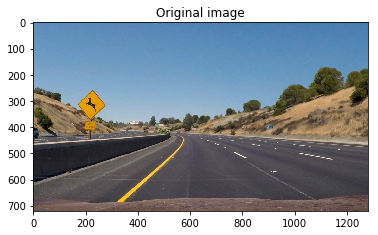

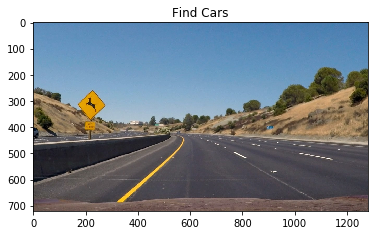

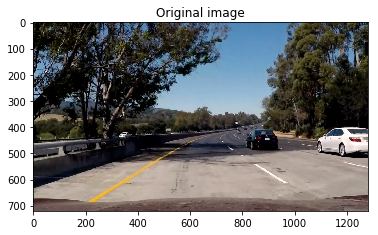

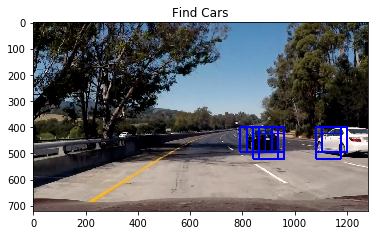

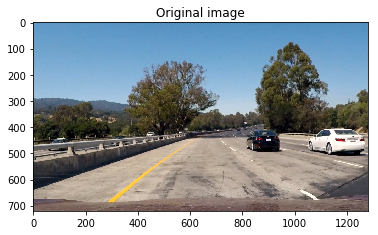

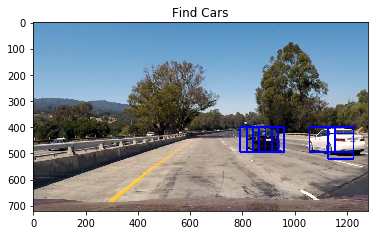

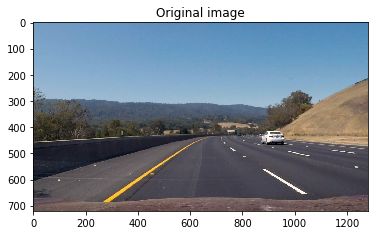

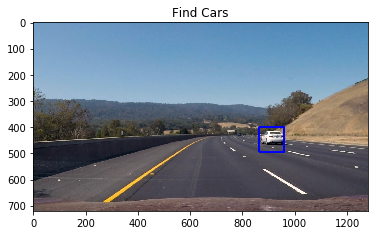

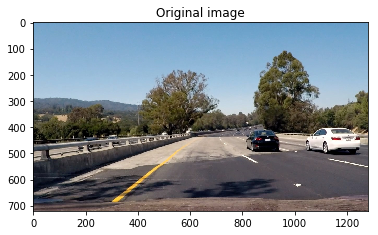

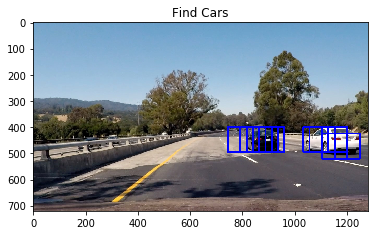

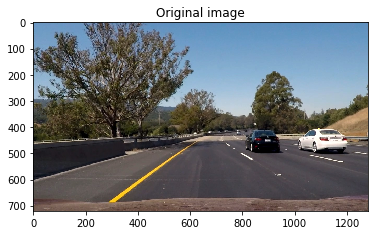

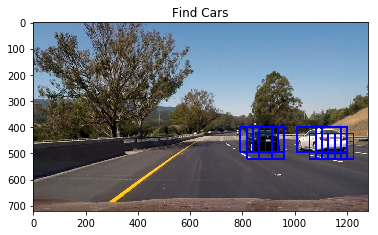

In [95]:
for idx, img_path in enumerate(glob.glob('test_images/*.jpg')):
    img = mpimg.imread(img_path)
    draw_img, bbox_list = find_cars(img, svc, X_scaler)
    plt.figure()
    plt.imshow(img)
    plt.title('Original image')
    plt.figure()
    plt.imshow(draw_img)
    plt.title('Find Cars')

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

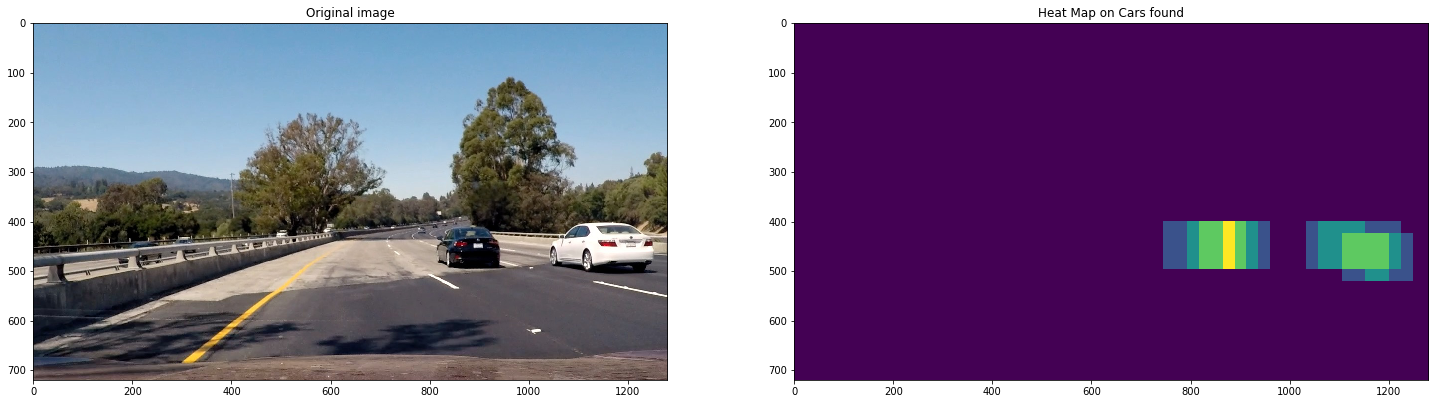

In [29]:
img = mpimg.imread('test_images/test4.jpg')
draw_img, bbox_list = find_cars(img, svc, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heatmap, bbox_list)
fig = plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(img)
plt.title('Original image')
plt.subplot(122)
plt.imshow(heat)
plt.title('Heat Map on Cars found')

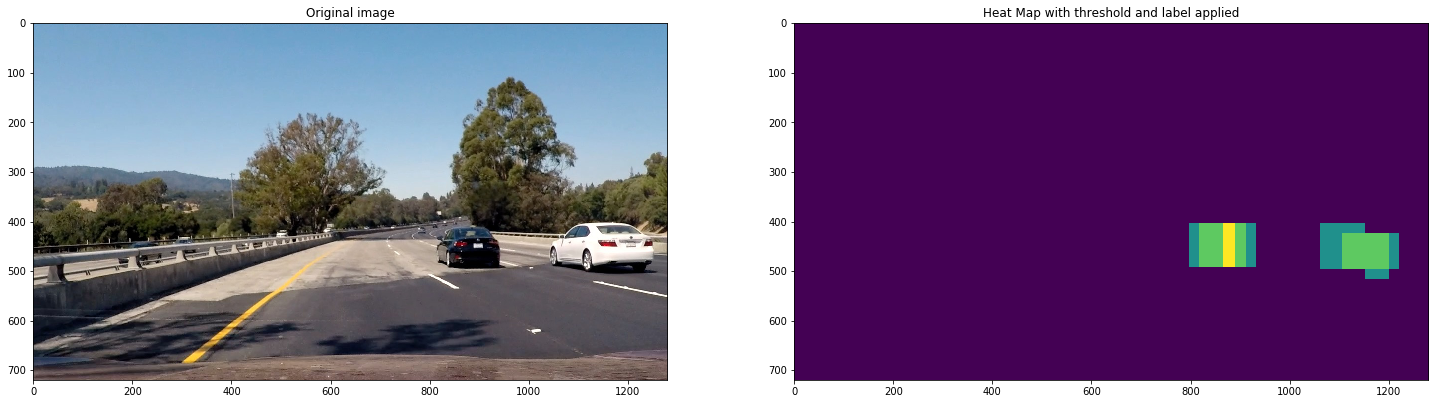

In [39]:
img = mpimg.imread('test_images/test4.jpg')
draw_img, bbox_list = find_cars(img, svc, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heatmap, bbox_list)
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
threshold = draw_labeled_bboxes(heat, labels)
fig = plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(img)
plt.title('Original image')
plt.subplot(122)
plt.imshow(threshold)
plt.title('Heat Map with threshold and label applied')

In [115]:
def process_frame(img):
    """
    Processes one frame of an image

    Inputs:
    - img : Frame as color image
    """
    global smoothing_counter, boxes

    smoothing_window = 20
    # First find cars in the image
    draw_img, bbox_list = find_cars(img, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2,
                                       spatial_size=(16, 16), hist_bins=16, scale=1.5)
    # Add heat map
    boxes.append(bbox_list)
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    if smoothing_counter > smoothing_window:
        for i in range(0, smoothing_window):
            heat = add_heat(heat, boxes[-i])
        heat = apply_threshold(heat, 1*smoothing_window)
    else:
        heat = add_heat(heat, bbox_list)
        heat = apply_threshold(heat, 1)
    smoothing_counter += 1

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [114]:
smoothing_counter=0
boxes=[]
out_clip = VideoFileClip("project_video.mp4").fl_image(process_frame)
%time out_clip.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:48<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 11min 2s, sys: 1.35 s, total: 11min 3s
Wall time: 5min 49s


In [31]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

In [119]:
smoothing_counter=0
boxes=[]
out_clip = VideoFileClip("test_video.mp4").fl_image(process_frame)
%time out_clip.write_videofile('test_video_output.mp4', audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 16.3 s, sys: 60.7 ms, total: 16.3 s
Wall time: 11.4 s


In [32]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_output.mp4'))